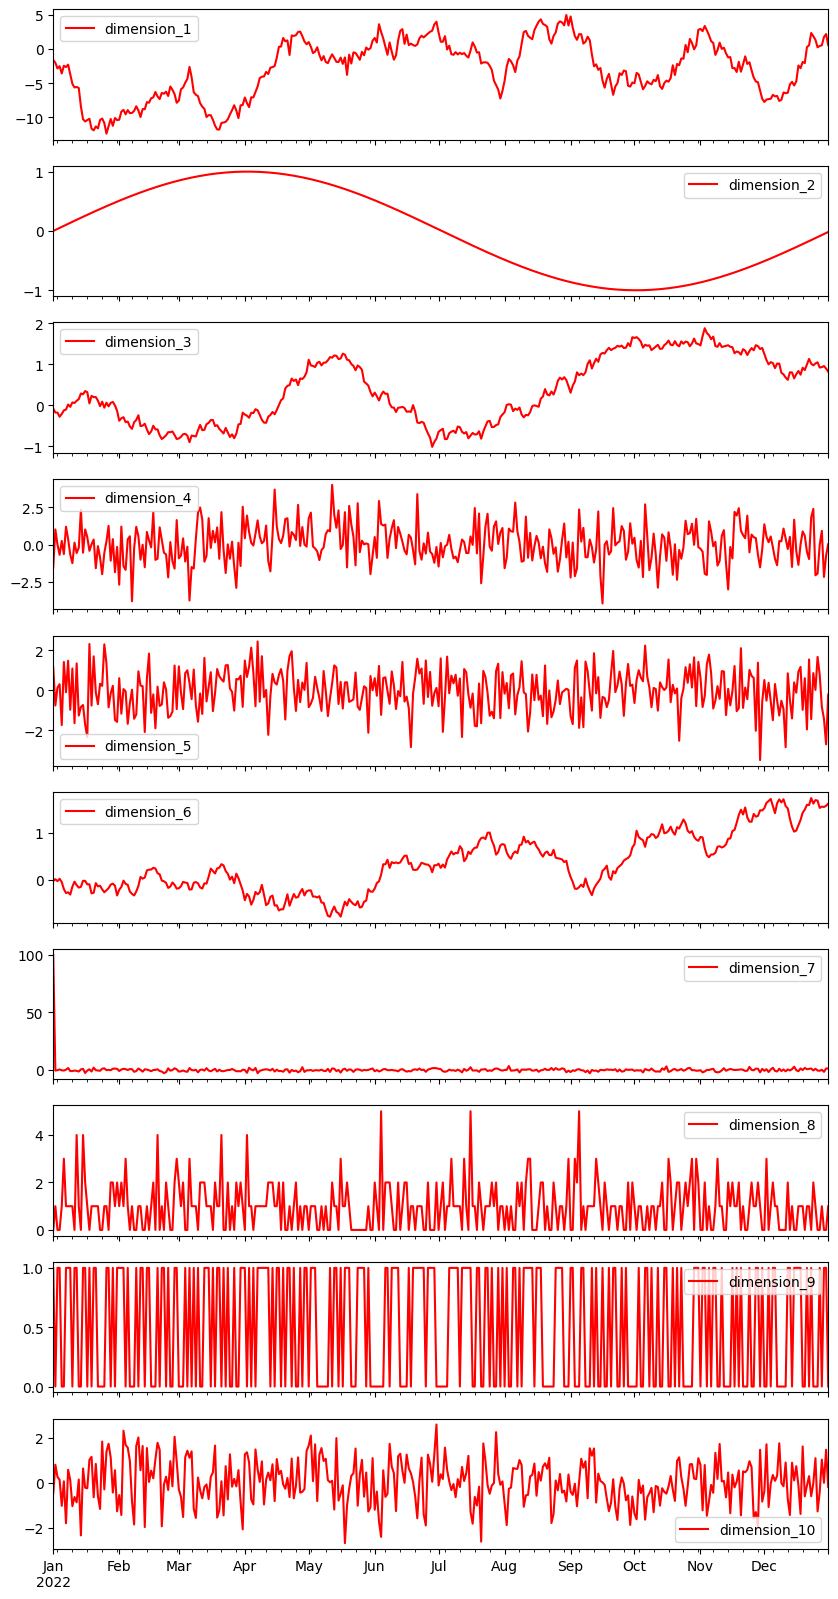

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the time range
start_date = '2022-01-01'
end_date = '2022-12-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Define the patterns for each data stream using a dictionary of lambda functions
sensors = [
    lambda data: np.cumsum(data),
    lambda data: np.sin(2 * np.pi * (date_range.dayofyear - 1) / 365),
    lambda data: 0.1 * np.cumsum(data) + np.linspace(0, 1, len(date_range)),
    lambda data: np.array([np.random.randn()] + [0.9 * data[j-1] + np.random.randn() for j in range(1, len(date_range))]),
    lambda data: np.array([np.random.randn()] + [np.random.randn() + 0.5 * data[j-1] for j in range(1, len(date_range))]),
    lambda data: 0.1 * np.cumsum(data) + np.sin(2 * np.pi * date_range.dayofyear / 365),
    lambda data: np.array([100 if j == 0 else data[j-1] * np.exp((0.1 - 0.5 * 0.2**2) * 1/365 + 0.2 * np.sqrt(1/365) * np.random.randn()) for j in range(len(date_range))]),
    lambda data: np.random.poisson(1, size=len(date_range)),
    lambda data: np.random.binomial(1, 0.5, size=len(date_range))
]

# Generate 10 random data streams using the lambda functions
data = np.random.randn(len(date_range), 10)
for i, sensor in enumerate(sensors):
    data[:, i] = sensor(data[:, i])

# Convert the data to a Pandas DataFrame
df = pd.DataFrame(data, index=date_range, columns=[f'dimension_{i}' for i in range(1, 11)])

# Plot the data
df.plot(subplots=True, figsize=(10, 20), color="r")
plt.show()


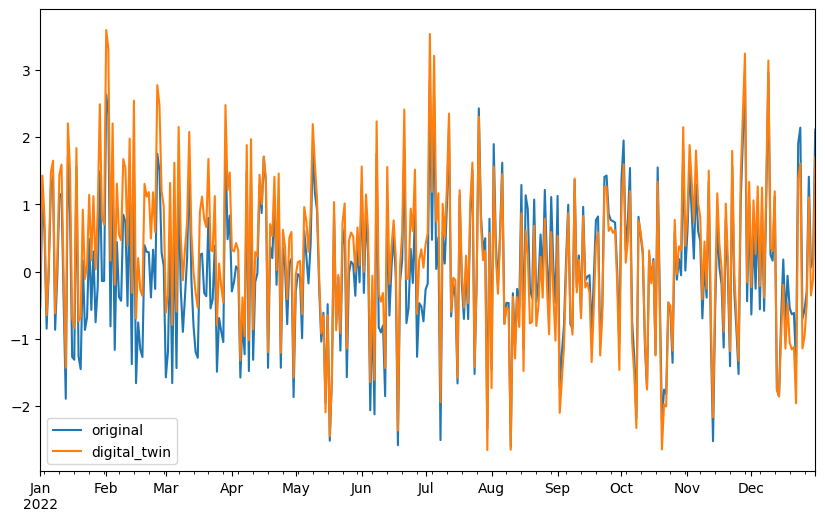

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

NOISE_MAGNITUDE = 0.1

# Define the time range
start_date = '2022-01-01'
end_date = '2022-12-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

og_func = lambda data: np.array([np.random.randn()] + [np.random.randn() + 0.5 * data[j-1] for j in range(1, len(date_range))])

data = og_func(np.zeros(len(date_range)))
noise = np.cumsum(np.random.randn(len(data)))
prediction = data + NOISE_MAGNITUDE * noise

# # Convert the data to a Pandas DataFrame
df = pd.DataFrame({
    'original': data,
    'digital_twin': prediction
    },
    index=date_range
)

# Plot the data
df.plot(figsize=(10, 6))
plt.show()


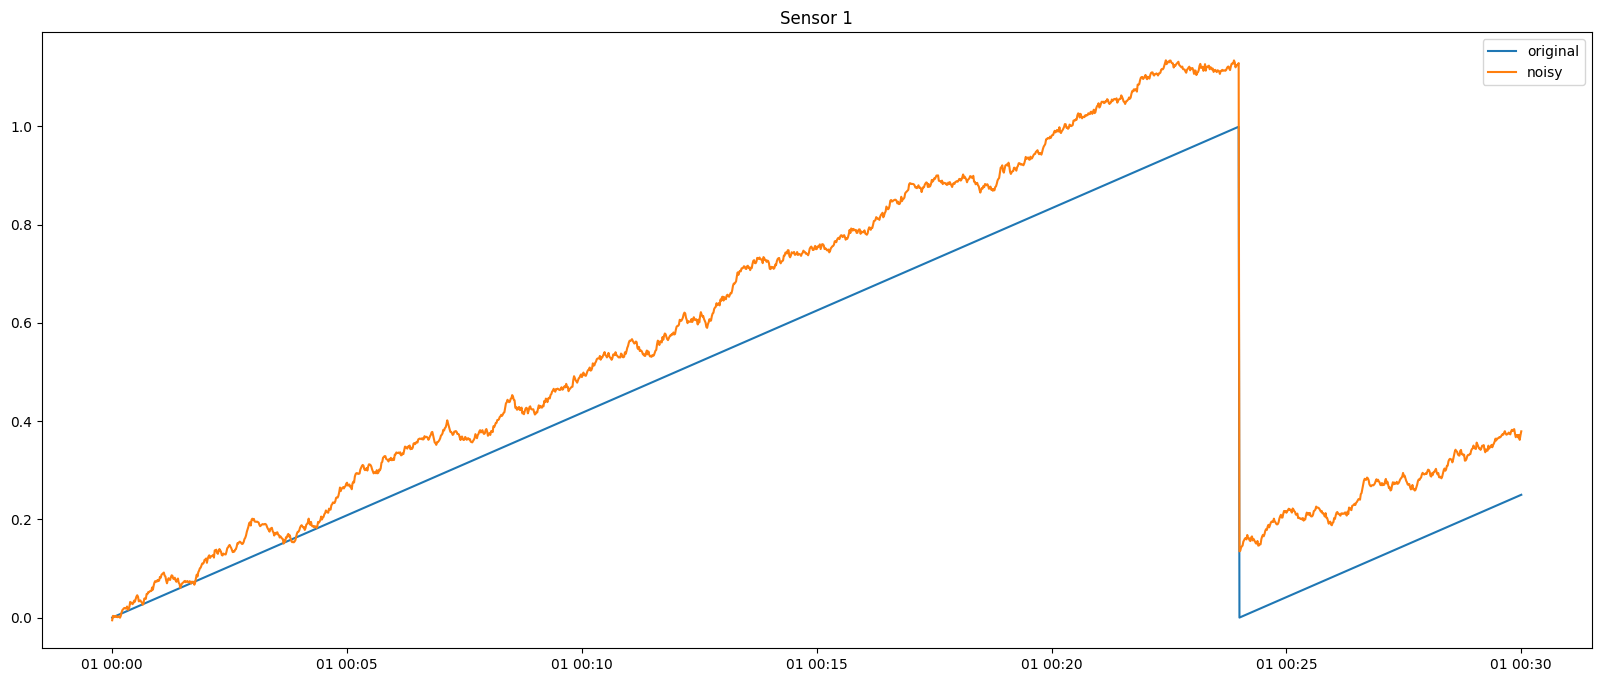

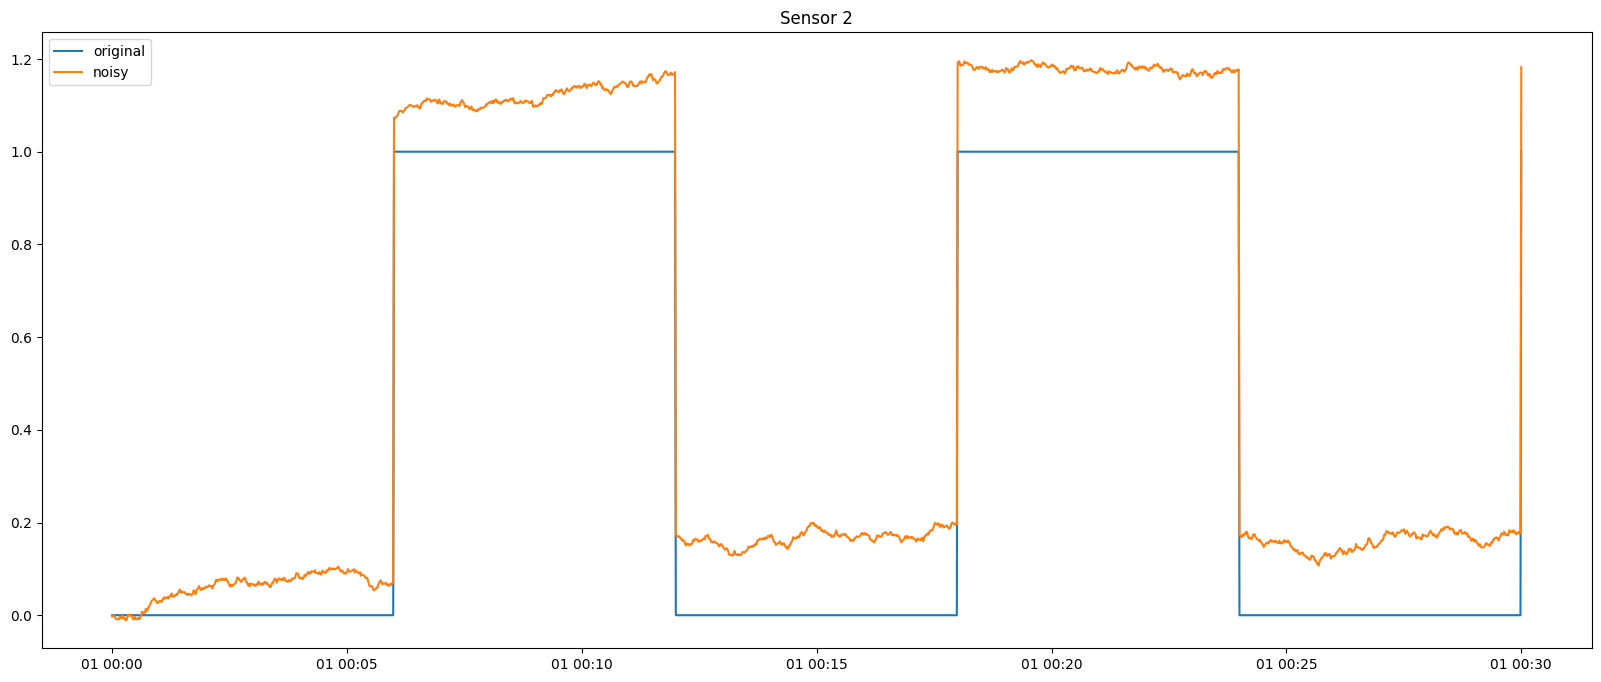

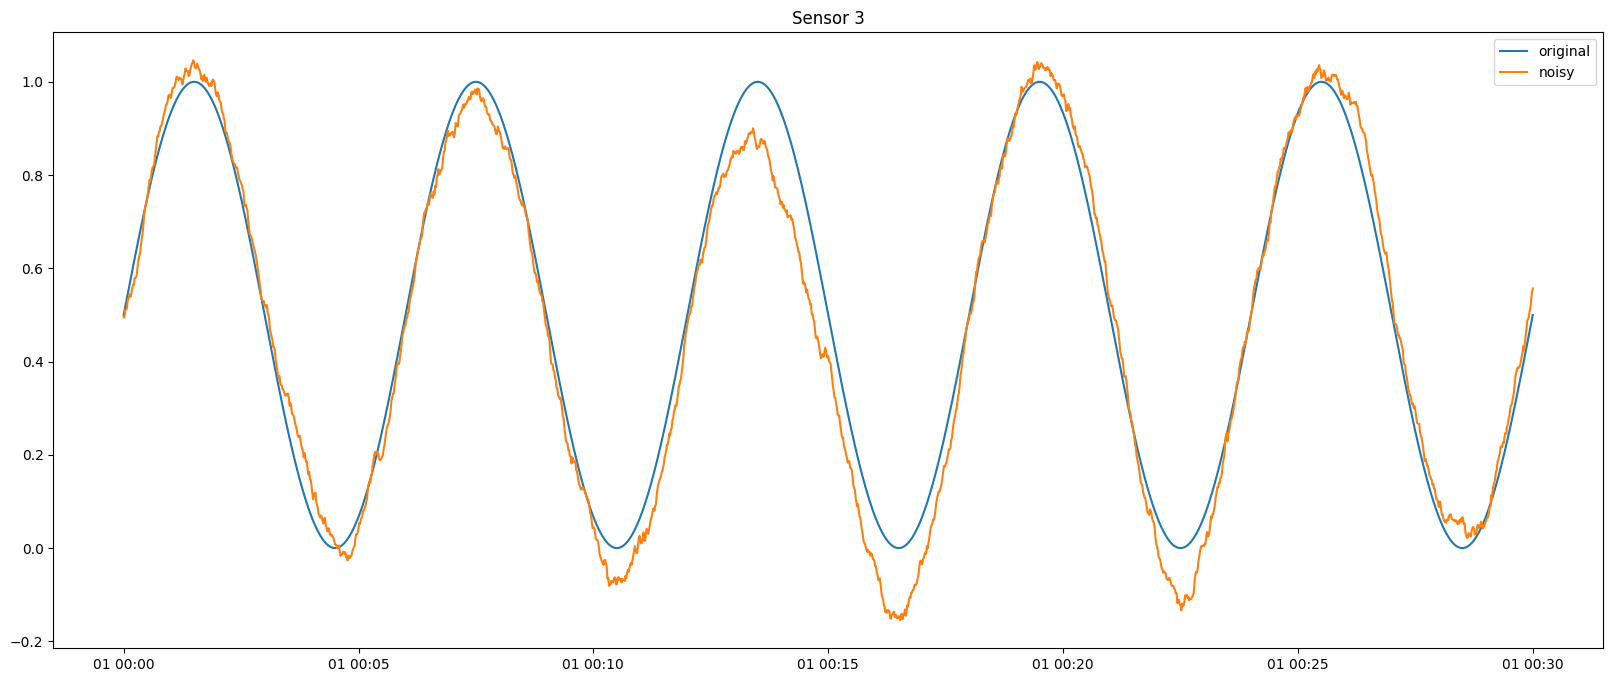

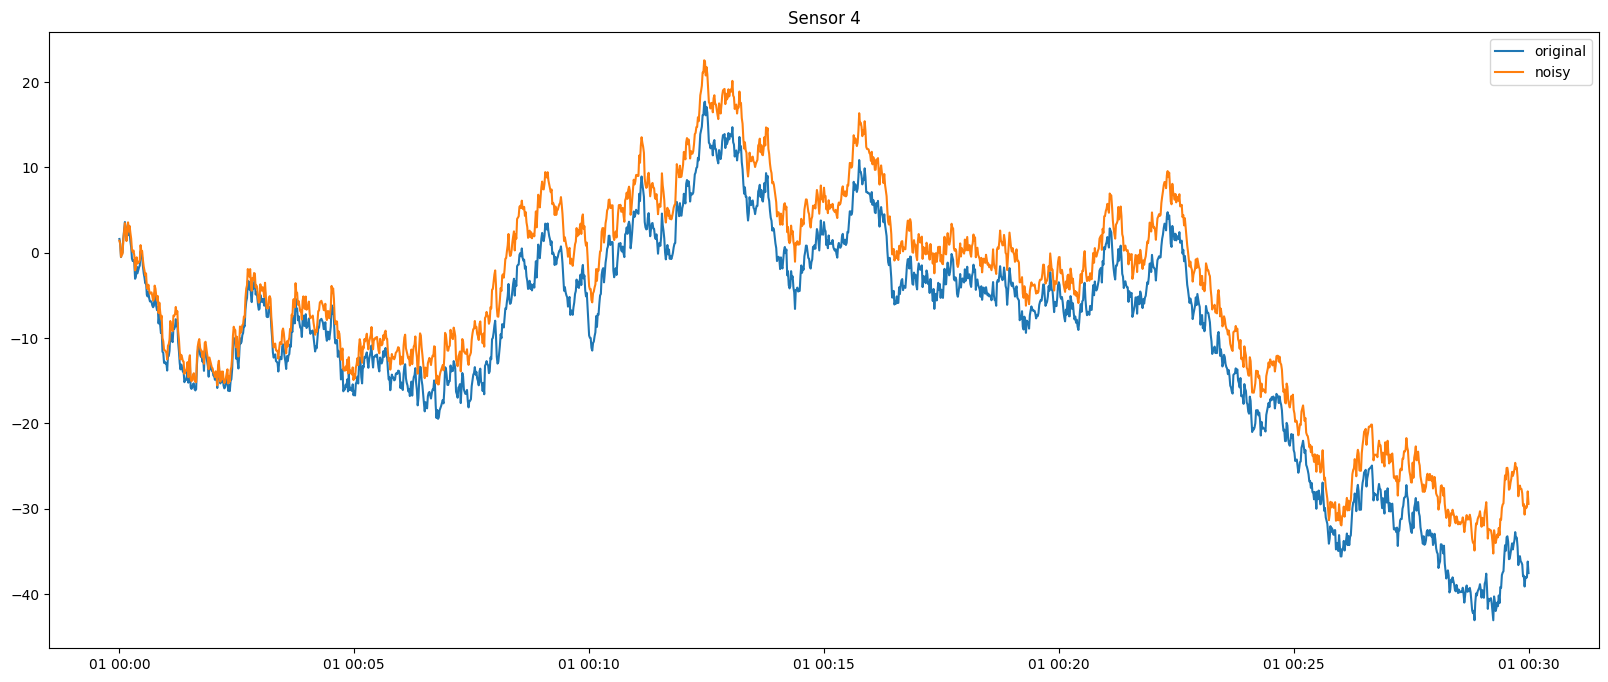

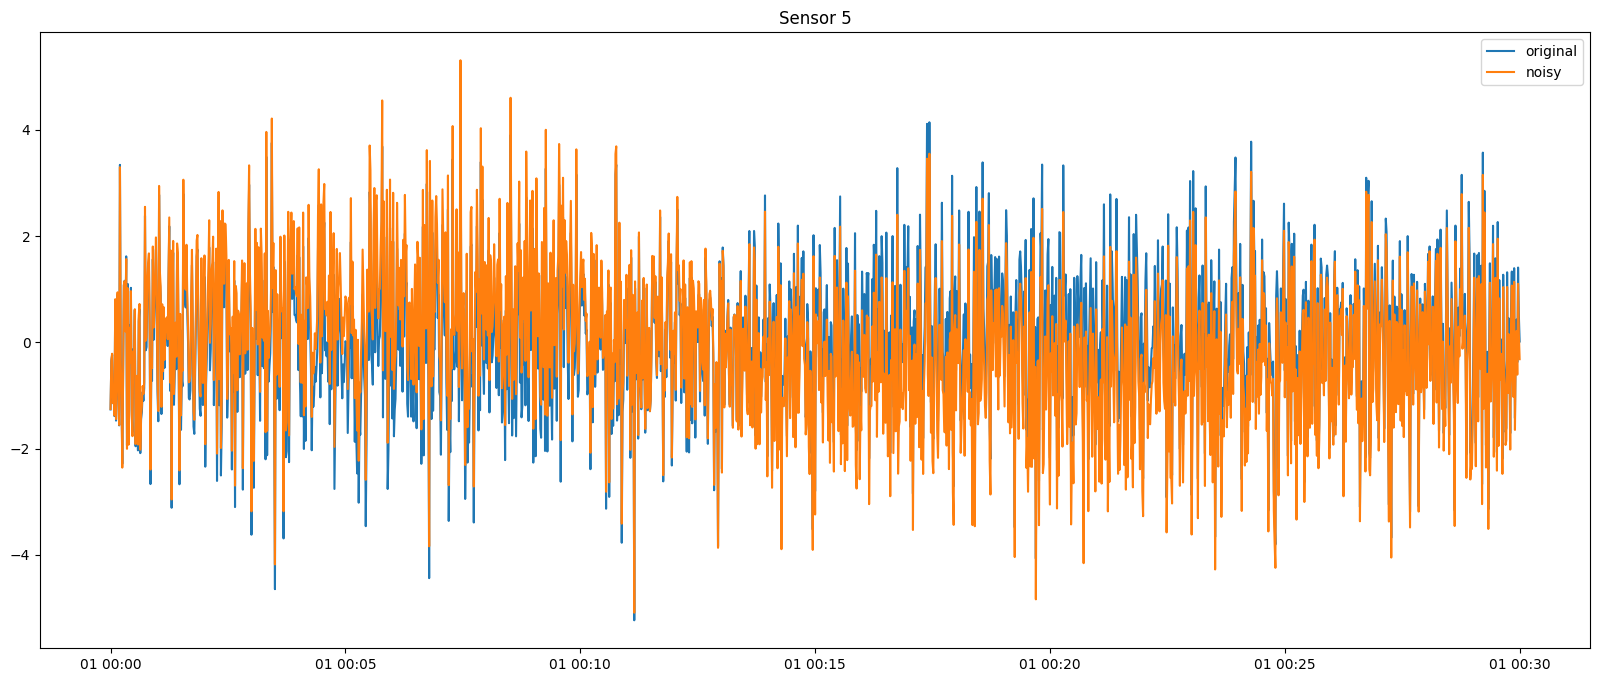

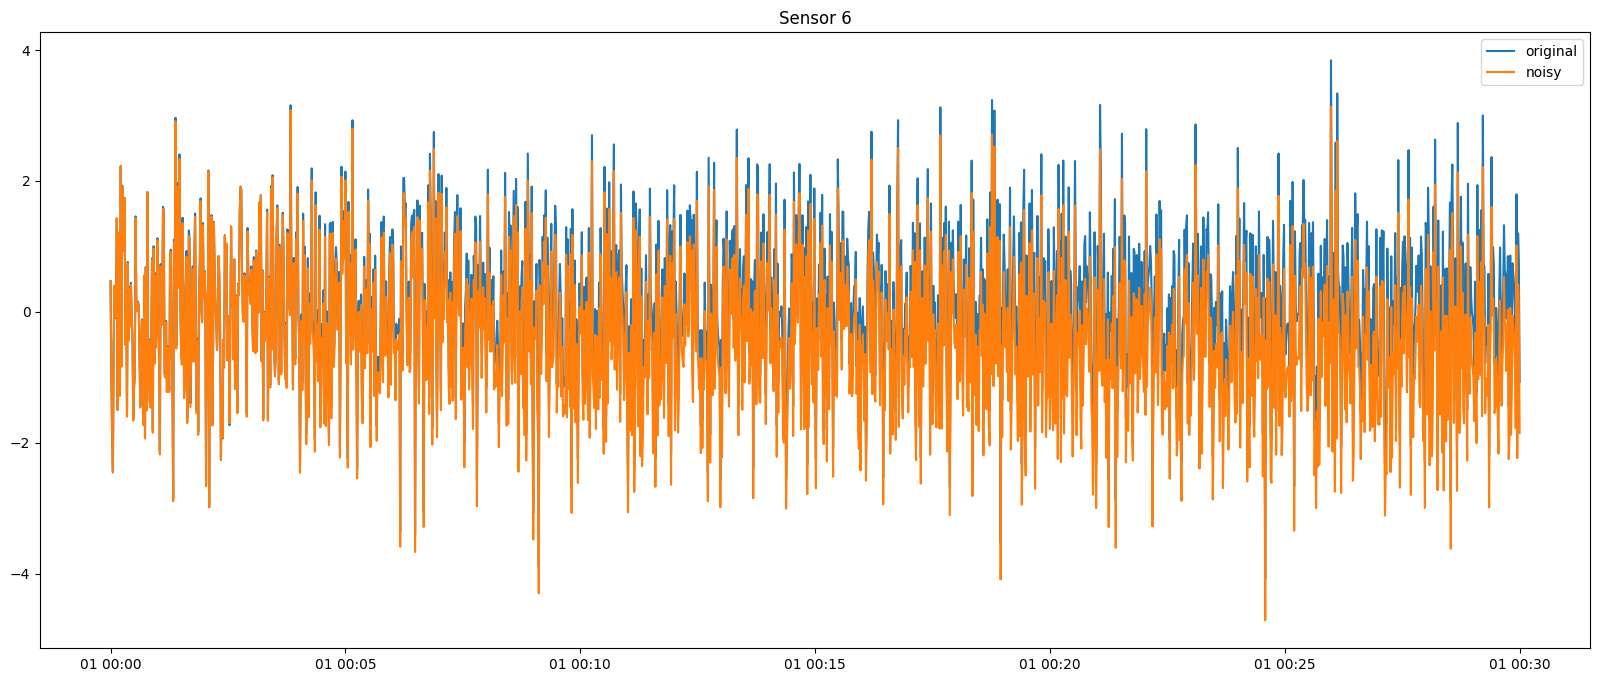

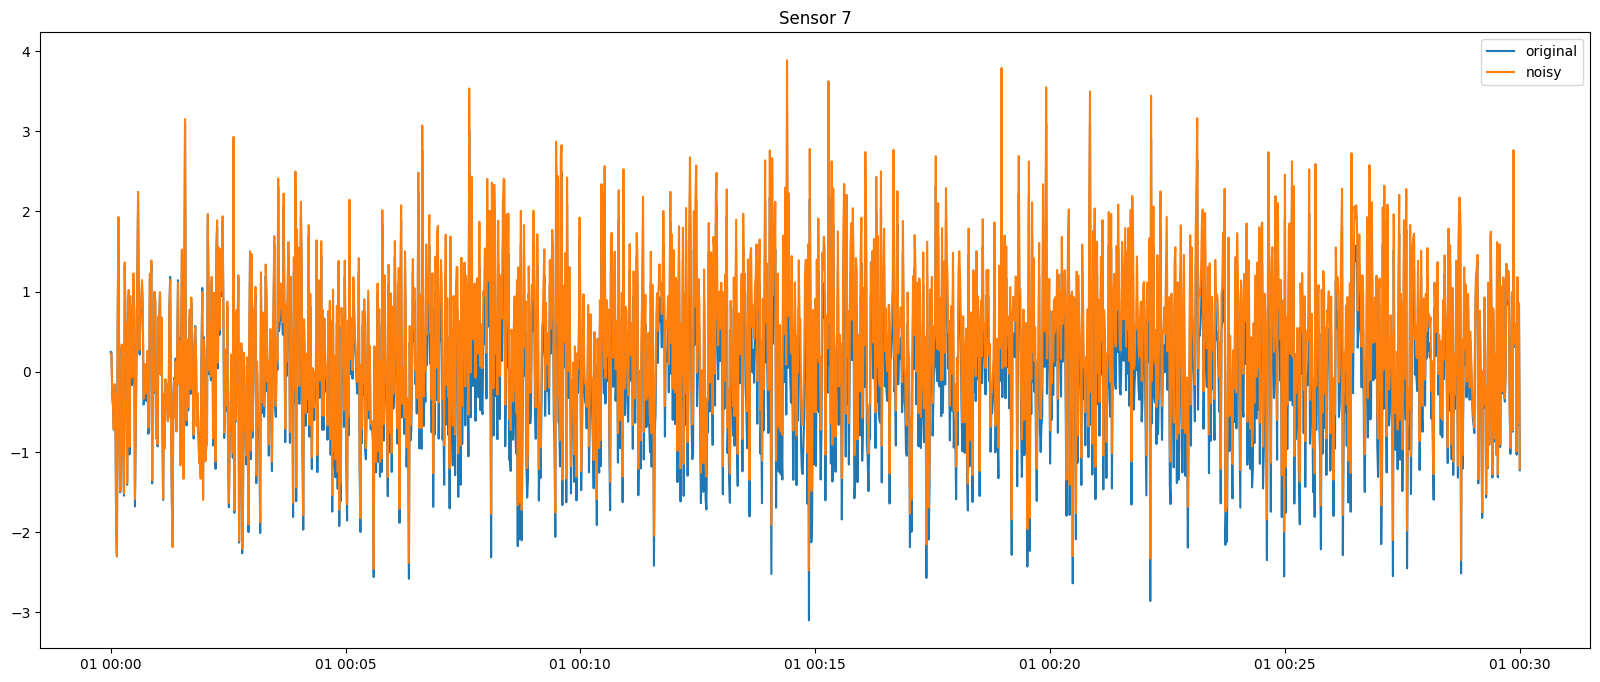

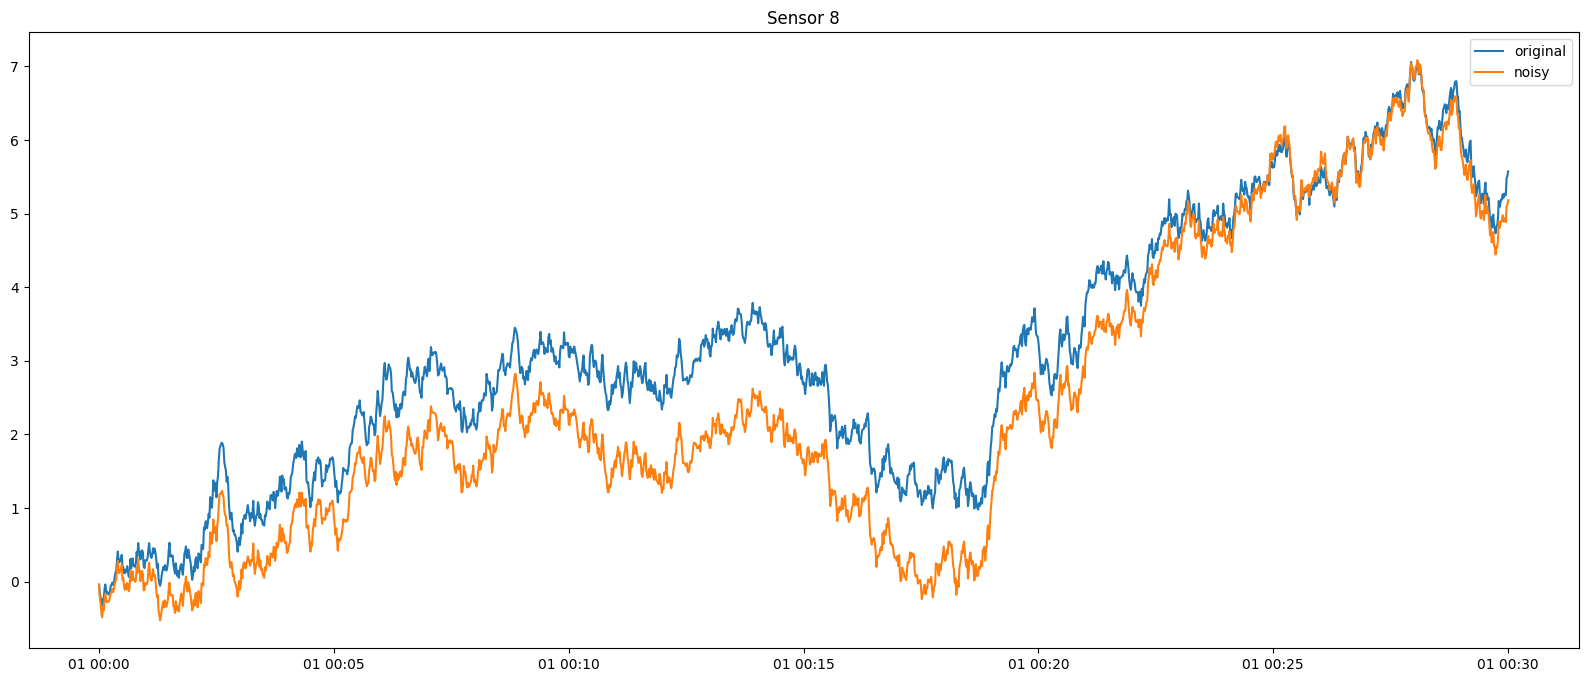

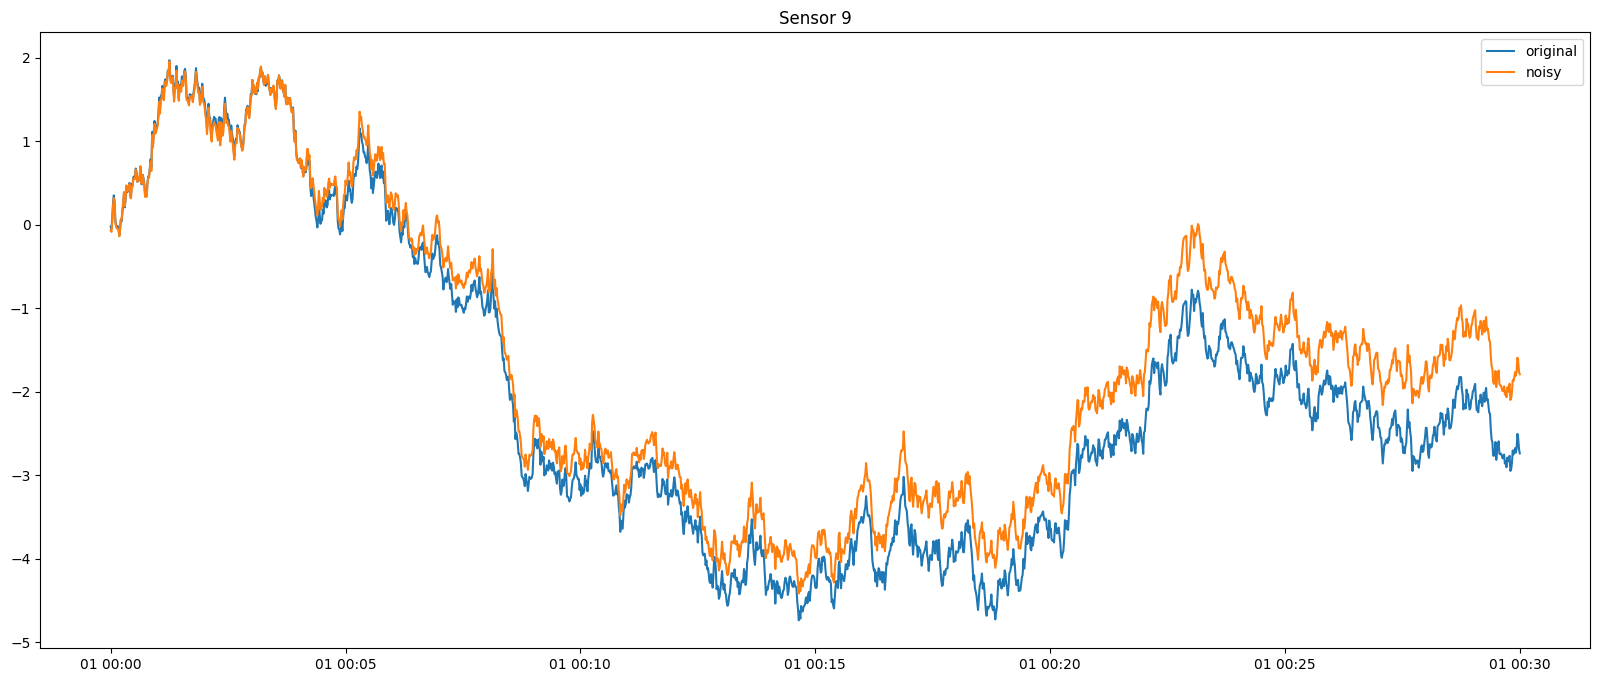

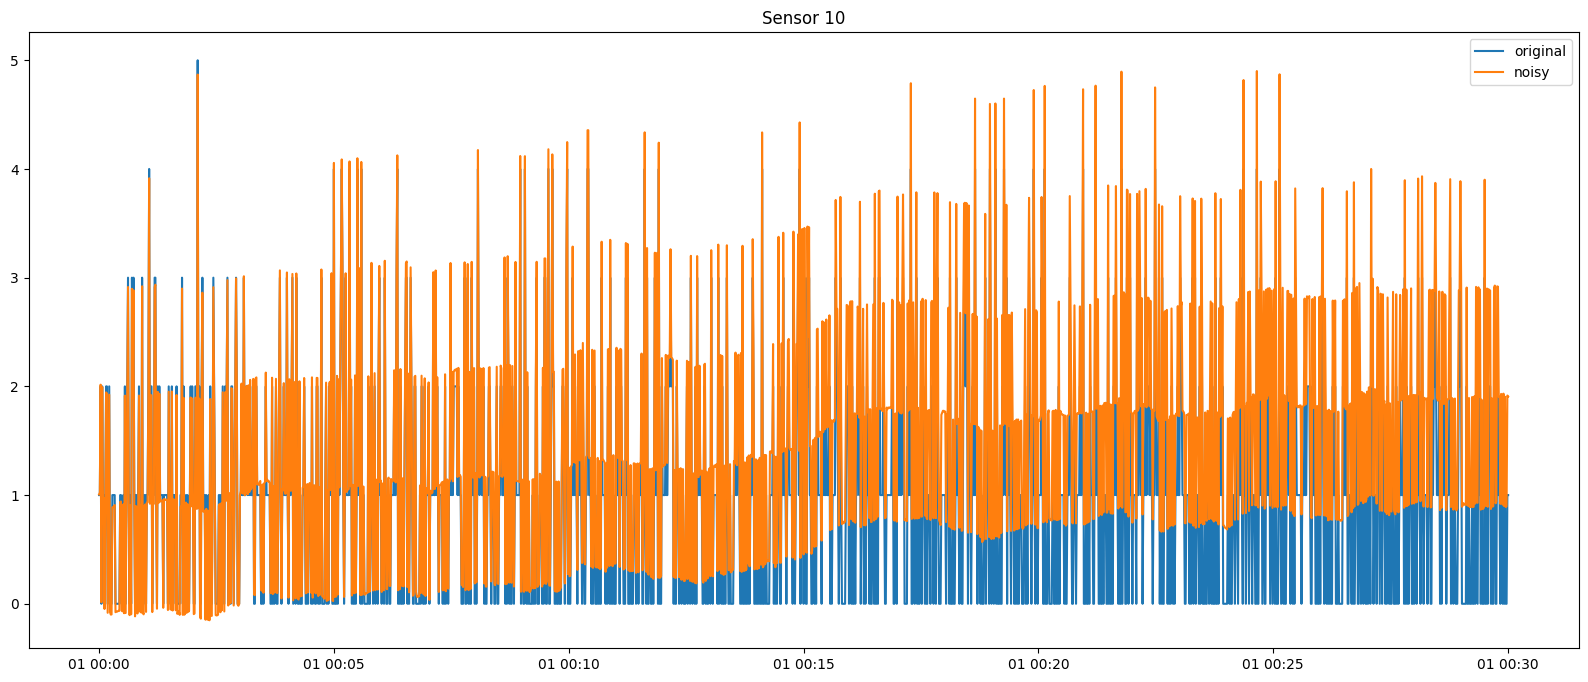

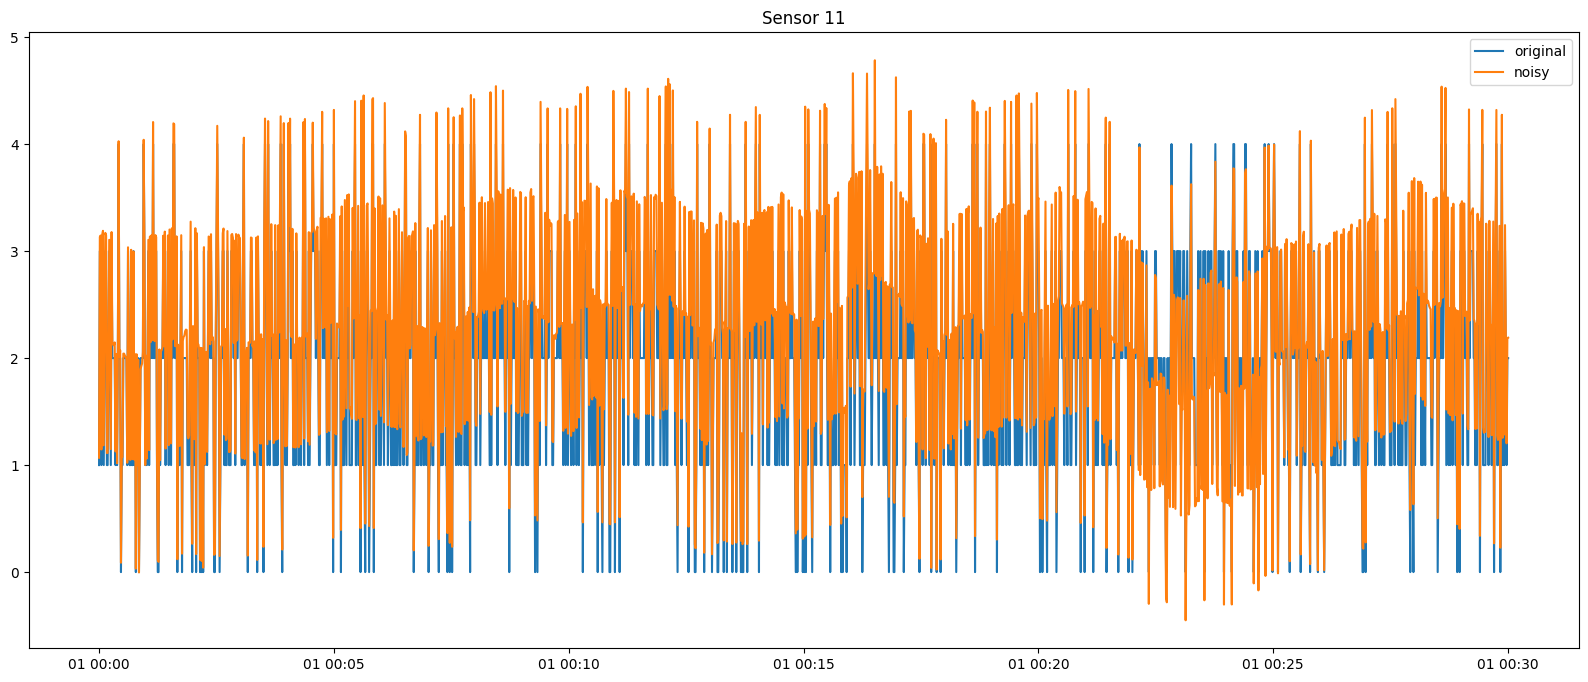

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

NOISE_MAGNITUDE = 0.2

# Define the time range with a one-day interval in seconds
start_date = '2022-01-01 00:00:00'
end_date = '2022-01-01 00:30:00'
date_range = pd.date_range(start=start_date, end=end_date, freq='S')
num_samples = len(date_range)

sensors = [    
    lambda data: (np.arange(num_samples) % (24*60)) / (24*60),
    lambda data: (np.arange(num_samples) % (12*60) >= (12*60)/2).astype(float),
    lambda data: 0.5 * np.sin(2 * np.pi * np.arange(num_samples) / (6*60)) + 0.5,
    lambda data: np.cumsum(data),
    lambda data: np.array([data[0]] + [0.9 * data[j-1] + np.random.randn() for j in range(1, num_samples)]),
    lambda data: np.array([data[0]] + [np.random.randn() + 0.5 * data[j-1] for j in range(1, num_samples)]),
    lambda data: np.array([data[0]] + [data[j-1] * np.exp((0.1 - 0.5 * 0.2**2) * 1/365 + 0.2 * np.sqrt(1/365) * np.random.randn()) for j in range(1, num_samples)]),
    lambda data: 0.1 * np.cumsum(data) + np.linspace(0, 1, num_samples),
    lambda data: 0.1 * np.cumsum(data) + np.sin(2 * np.pi * date_range.dayofyear / 365),
    lambda data: np.random.poisson(1, size=num_samples),
    lambda data: np.random.binomial(4, 0.5, size=num_samples),
]

# Generate 10 random data streams using the lambda functions
data = np.random.randn(len(date_range), len(sensors))
for i, sensor in enumerate(sensors):
    sensor_data = sensor(data[:, i])
    data[:, i] = sensor_data

# Plot the data and their noise for each function
for i in range(len(sensors)):
    plt.figure(figsize=(20, 8))
    original_data = data[:, i]
    
    noise = np.cumsum(np.random.randn(len(original_data)))
    ratio = np.max(np.abs(original_data)) / np.max(np.abs(noise))
    noisy_data = original_data + NOISE_MAGNITUDE * noise * ratio
    
    plt.plot(date_range, original_data, label='original')
    plt.plot(date_range, noisy_data, label='noisy')
    plt.title(f'Sensor {i+1}')
    plt.legend()
    plt.show()
    
